# Supervised and Unsupervised Learning on MNIST

## Dataset Introduction and Visualization

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.manifold import TSNE
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
pl.seed_everything(42)

Seed set to 42


42

In [3]:
def prepare_data(sklearn=True, batch_size=128,
                val_partition=0.1, random_state=42):
    """
    Prepare MNIST data for training and evaluation.
    """
    if sklearn:
        mnist_train = datasets.MNIST(root='data/', train=True, download=True)
        mnist_test = datasets.MNIST(root='data/', train=False, download=True)

        X_train = mnist_train.data.numpy().reshape(-1, 784).astype('float32') / 255.0
        y_train = mnist_train.targets.numpy()
        X_test = mnist_test.data.numpy().reshape(-1, 784).astype('float32') / 255.0
        y_test = mnist_test.targets.numpy()

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        return X_train, y_train, X_test, y_test

    else:
        transform = transforms.Compose([transforms.ToTensor()])

        train_val_dataset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root='data/', train=False, download=True, transform=transform)

        total_train = len(train_val_dataset)
        val_size = int(val_partition * total_train)
        train_size = total_train - val_size
        train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size],
                                                generator=torch.Generator().manual_seed(random_state))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader, test_loader


In [4]:
X_train, y_train, X_test, y_test = prepare_data(sklearn=True)
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (60000, 784)
y_train: (60000,)
X_test: (10000, 784)
y_test: (10000,)


In [5]:
train_loader, val_loader, test_loader = prepare_data(sklearn=False)
print('Train:', len(train_loader.dataset))
print('Val:', len(val_loader.dataset))
print('Test:', len(test_loader.dataset))

Train: 54000
Val: 6000
Test: 10000


In [6]:
def pixel_space_visualization(X_train, y_train):
    """
    Visualize MNIST data in pixel space.
    """
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
        ax.set_title(str(y_train[i]))
        ax.axis('off')
    plt.show()

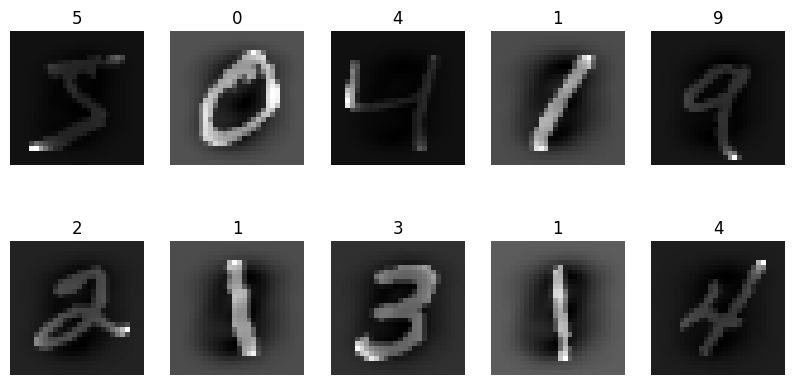

In [7]:
pixel_space_visualization(X_train, y_train)
# Note that this is the preprocessed data, so the images may look slightly different from the original MNIST dataset.

In [8]:
def low_dim_visualization(data, labels, method='tsne', cache_path="reduced_data.joblib"):
    """
    Display a 2D visualization of the dataset using t-SNE or other methods with caching.
    """
    if os.path.exists(cache_path):
        print(f"Loading reduced data from {cache_path}")
        data_2d = joblib.load(cache_path)
    else:
        print(f"Reducing data using {method.upper()}...")
        if method == 'tsne':
            reducer = TSNE(n_components=2, random_state=42)
            data_2d = reducer.fit_transform(data)
        else:
            raise ValueError(f"Method '{method}' not supported.")
        
        print(f"Saving reduced data to {cache_path}")
        joblib.dump(data_2d, cache_path)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='tab10', alpha=0.6, s=3)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(f"2D visualization using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

Loading reduced data from cache/tsne_reduced_data_train.joblib


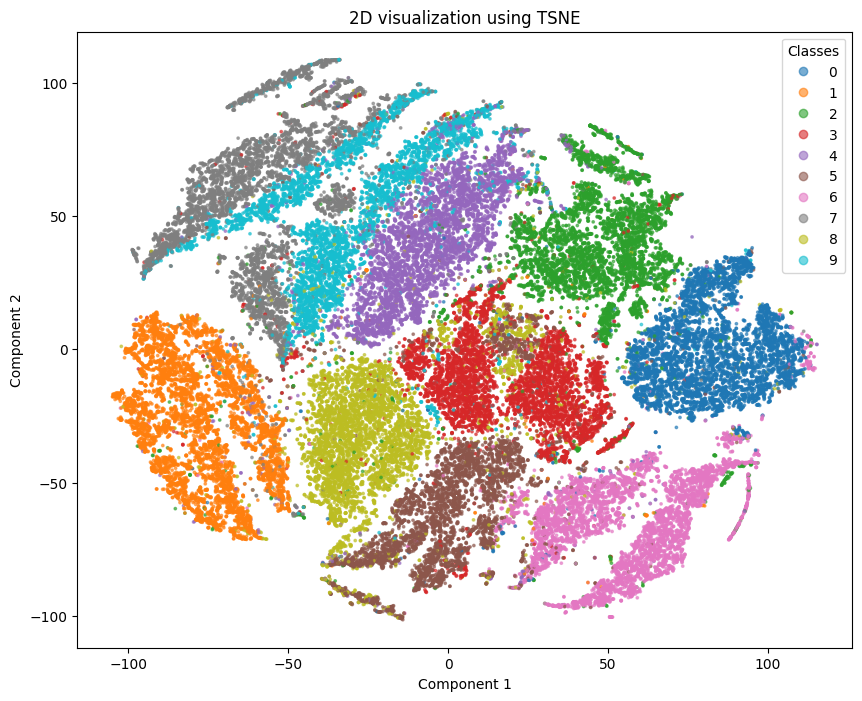

In [9]:
low_dim_visualization(X_train, y_train, method='tsne', cache_path="cache/tsne_reduced_data_train.joblib")

## Supervised Learning

In [10]:
def evaluate_model(model_path, plot_title, is_nn=False, nn_model_instance=None, device='cpu'):
    """
    Load a model (traditional or NN), make predictions on test data, and plot confusion matrix and classification report.
    """
    print("Loading model and test data...")

    y_pred = None
    if is_nn:
        if nn_model_instance is None:
            raise ValueError("nn_model_instance must be provided for NN models.")
        
        nn_model_instance.to(device)
        nn_model_instance.eval()
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad():
                y_pred_batch = nn_model_instance(X_batch)
                y_pred_batch = torch.argmax(y_pred_batch, dim=1)
            y_pred = y_pred_batch if y_pred is None else torch.cat([y_pred, y_pred_batch], dim=0)

    else:
        model = joblib.load(model_path)["final_model"]
        X_test_prepped = X_test
        y_pred = model.predict(X_test_prepped)


    print("Calculating accuracy...")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Final Accuracy: {accuracy:.4f}")

    classes = [str(i) for i in range(10)]

    print("Generating evaluation plots...")
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
    report_df = pd.DataFrame(report).iloc[:-1, :].T

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=axes[0])
    axes[0].set_title(f"{plot_title} - Confusion Matrix")
    axes[0].set_xlabel('Predicted Labels')
    axes[0].set_ylabel('True Labels')

    sns.heatmap(report_df, annot=True, cmap="coolwarm", ax=axes[1])
    axes[1].set_title(f"{plot_title} - Classification Report")
    axes[1].set_xlabel('Metrics')
    axes[1].set_ylabel('Classes')

    plt.tight_layout()
    plt.show()


### Logistic Regression

In [11]:
def train_logistic_regression(X, y, cv=5):
    strategies = ['multinomial', 'ovr']
    results = {}
    print("Comparing Logistic Regression strategies with cross-validation...")
    for strategy in strategies:
        model = LogisticRegression(multi_class=strategy, solver='lbfgs', max_iter=1000)
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        
        mean_acc = np.mean(scores)
        std_acc = np.std(scores)
        results[strategy] = mean_acc
        print(f"\nStrategy: {strategy}")
        print(f"Cross-validated Accuracy: {mean_acc:.4f} (±{std_acc:.4f})")

    best_strategy = max(results, key=results.get)
    print(f"Best strategy: {best_strategy}")

    final_model = LogisticRegression(multi_class=best_strategy, solver='lbfgs', max_iter=1000)
    final_model.fit(X, y)

    # let's see if 1000 iterations were enough
    if hasattr(final_model, "n_iter_"):
        print(f"Number of iterations: {final_model.n_iter_[0]}")
        if final_model.n_iter_[0] < 1000:
            print("The model converged before reaching max_iter.")
        else:
            print("The model reached max_iter without convergence.")
    else:
        print("The solver used does not expose the number of iterations.")

    print("Saving final model...")
    joblib.dump({
        "final_model": final_model
    }, "cache/final_logistic_model.joblib")

In [ ]:
#train_logistic_regression(X_train, y_train)

Comparing Logistic Regression strategies with cross-validation...


/opt/homebrew/Caskroom/miniconda/base/envs/mnist/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/mnist/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/mnist/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/b


Strategy: multinomial
Cross-validated Accuracy: 0.9119 (±0.0057)


/opt/homebrew/Caskroom/miniconda/base/envs/mnist/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/mnist/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/mnist/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/ho


Strategy: ovr
Cross-validated Accuracy: 0.9119 (±0.0048)
Best strategy: ovr


/opt/homebrew/Caskroom/miniconda/base/envs/mnist/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Number of iterations: 61
The model converged before reaching max_iter.
Saving final model...


Loading model and test data...
Calculating accuracy...
Final Accuracy: 0.9179
Generating evaluation plots...


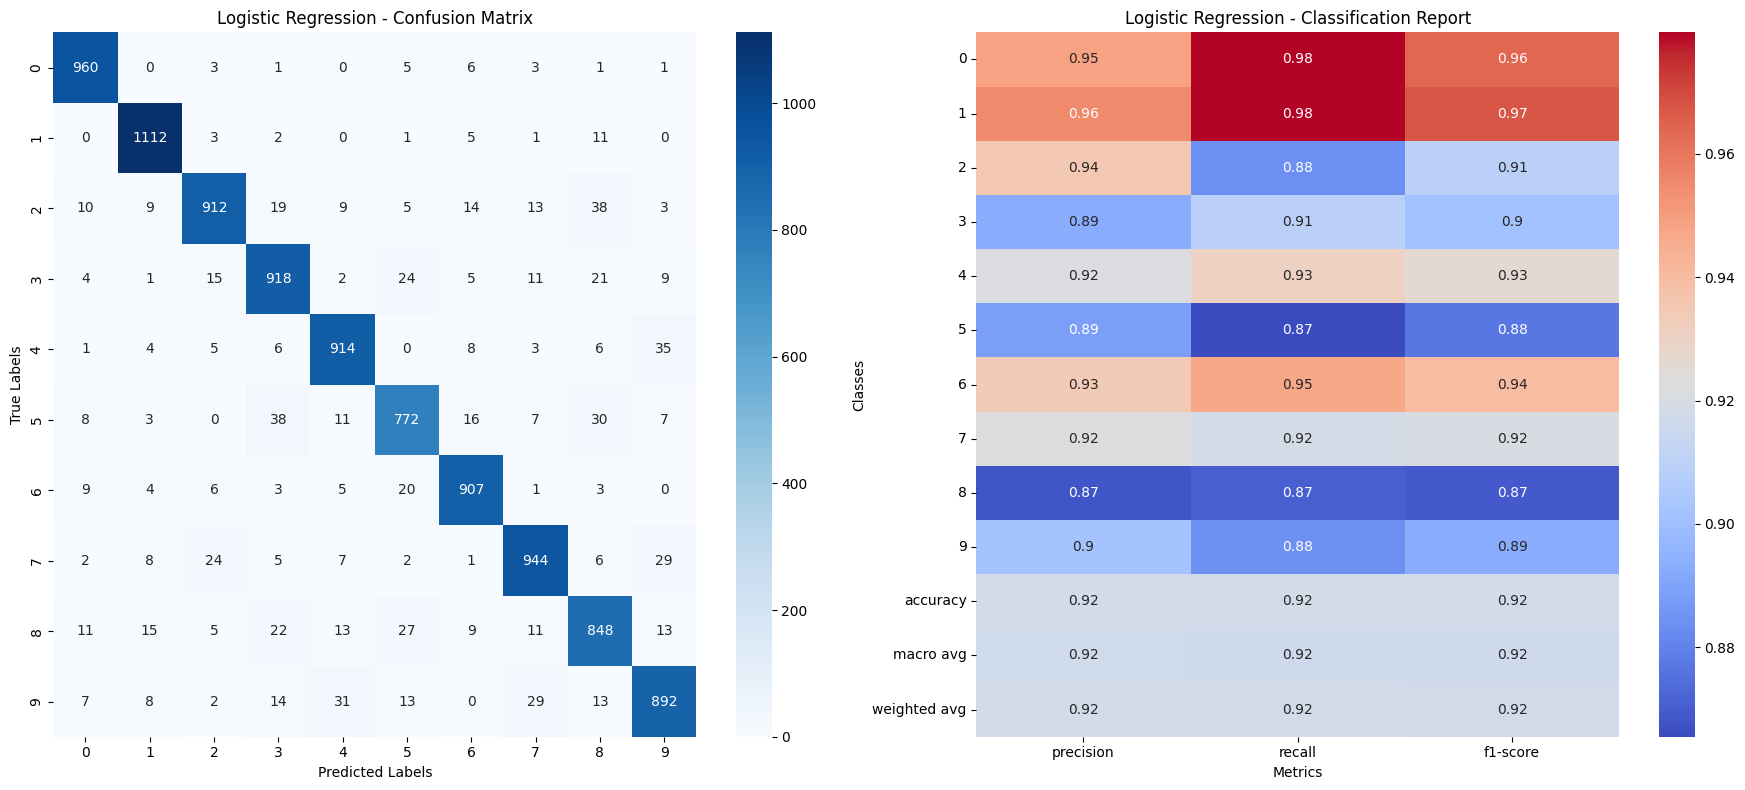

In [12]:
evaluate_model("cache/final_logistic_model.joblib", "Logistic Regression")

### Gradient Boosting Decision Tree

In [13]:
def train_lightgbm(learning_rates=[0.05, 0.1], num_leaves=31, cv = 5):
    """
    Train LightGBM using cross-validation and save the best model and hyperparameters.
    """
    print("\nTraining LightGBM with cross-validation...")
    results = []
    for lr in learning_rates:
        print(f"\nTesting: learning_rate={lr}, num_leaves={num_leaves}")
        model = LGBMClassifier(
            objective='multiclass',
            num_class=len(np.unique(y_train)),
            num_leaves=num_leaves,
            learning_rate=lr,
            random_state=42
        )

        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        mean_acc = np.mean(scores)
        print(f"Cross-validated Accuracy: {mean_acc:.4f}")

        results.append({'learning_rate': lr, 'mean_accuracy': mean_acc})

    best = max(results, key=lambda x: x['mean_accuracy'])
    print(f"\nBest Model: learning_rate={best['learning_rate']}, Accuracy={best['mean_accuracy']:.4f}")

    final_model = LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_train)),
        num_leaves=num_leaves,
        learning_rate=best['learning_rate'],
        random_state=42
    )
    final_model.fit(X_train, y_train)

    joblib.dump({
    "final_model": final_model
}, "cache/final_lightgbm_model.joblib")
    print("Final model and hyperparameters saved to cache.")

In [ ]:
#train_lightgbm()


Training LightGBM with cross-validation...

Testing: learning_rate=0.05, num_leaves=31
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 109744
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 623
[LightGBM] [Info] Start training from score -2.315375
[LightGBM] [Info] Start training from score -2.185914
[LightGBM] [Info] Start training from score -2.309484
[LightGBM] [Info] Start training from score -2.281150
[LightGBM] [Info] Start training from score -2.329400
[LightGBM] [Info] Start training from score -2.404249
[LightGBM] [Info] Start training from score -2.316219
[LightGBM] [Info] Start training from score -2.259366
[LightGBM] [Info] Start training from score -2.327689
[LightGBM] [Info] Start training from score -2.311163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

Loading model and test data...
Calculating accuracy...
Final Accuracy: 0.9785
Generating evaluation plots...


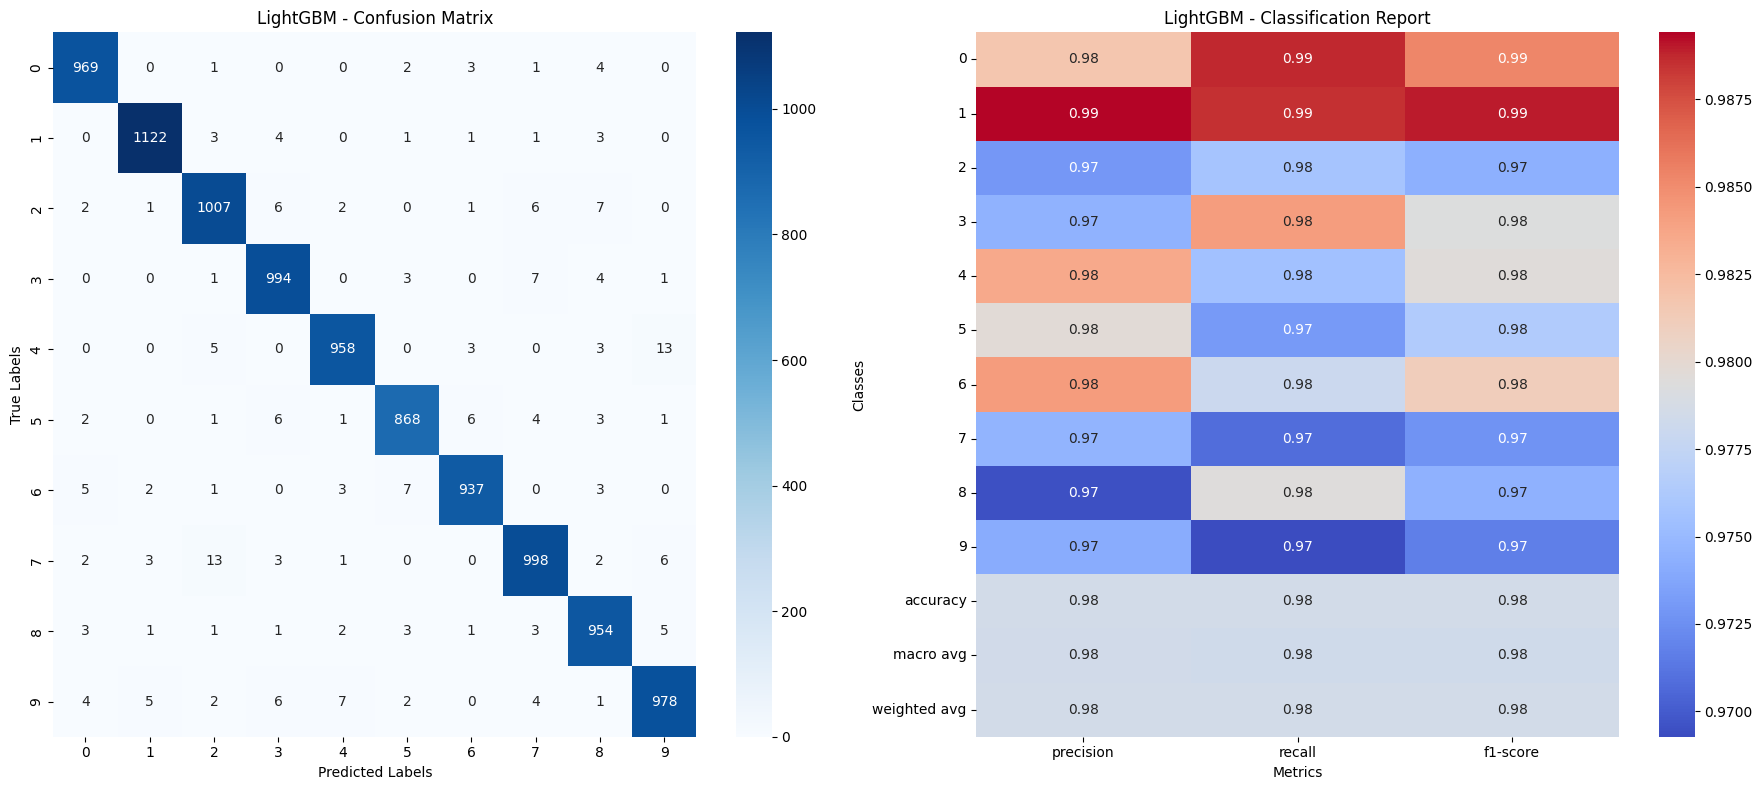

In [14]:
evaluate_model("cache/final_lightgbm_model.joblib", "LightGBM")

### Convolutional Neural Network (LeNet-5)

In [27]:
class BaseLightningModel(pl.LightningModule):
    """
    Base class for all neural network models.
    Handles logging, checkpointing, and common methods.
    """
    def __init__(self, model_name='BaseModel', learning_rate=1e-3):
        super().__init__()
        self.model_name = model_name
        self.learning_rate = learning_rate

        # Checkpoint callback
        self.checkpoint_callback = ModelCheckpoint(
            monitor='val_loss',
            filename='best',
            save_top_k=1,
            mode='min',
            save_last=True
        )
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def load_best_model(self):
        checkpoint_path = self.checkpoint_callback.best_model_path
        if checkpoint_path:
            self.load_state_dict(torch.load(checkpoint_path)['state_dict'])
            print(f"Loaded best model from {checkpoint_path}")
        else:
            print("No checkpoint found.")

    def plot_latent_space(self, latent_vectors, labels, title="Latent Space", vae = False):
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', alpha=0.6, s=3)
        plt.legend(*scatter.legend_elements(), title="Classes")
        plt.title(title)
        plt.xlabel("Latent Dimension 1")
        plt.ylabel("Latent Dimension 2")
        if vae:
            # heatmap the prior distribution N(0, 1)
            # adapt to range of current latent space
            x = np.linspace(latent_vectors[:, 0].min(), latent_vectors[:, 0].max(), 100)
            y = np.linspace(latent_vectors[:, 1].min(), latent_vectors[:, 1].max(), 100)
            X, Y = np.meshgrid(x, y)
            Z = np.exp(-0.5 * (X**2 + Y**2)) / (2 * np.pi)
            plt.contourf(X, Y, Z, alpha=0.3, cmap='coolwarm', levels=50)
        plt.show()

    def plot_reconstructed_images(self, original, reconstructed, num_images=8):
        original = original[:num_images].detach().cpu().numpy()
        recon = reconstructed[:num_images].detach().cpu().numpy()

        plt.figure(figsize=(num_images * 2, 4))
        for i in range(num_images):
            # Original
            plt.subplot(2, num_images, i + 1)
            plt.imshow(original[i].reshape(28, 28), cmap='gray')
            plt.axis('off')

            # Reconstructed
            plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(recon[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.suptitle("Original and Reconstructed Images")
        plt.show()

    def plot_generated_images(self, generated, num_images=8):
        generated = generated[:num_images].detach().cpu().numpy()

        plt.figure(figsize=(num_images * 2, 2))
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(generated[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.suptitle("Generated Images")
        plt.show()


In [16]:
class LeNetModel(BaseLightningModel):
    def __init__(self, learning_rate=1e-3):
        super().__init__(model_name='LeNet', learning_rate=learning_rate)
        # Original LeNet architecture
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _common_step(self, batch, stage):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log(f"{stage}_loss", loss, on_step=False, on_epoch=True, prog_bar=(stage != 'test'))
        self.log(f"{stage}_acc", acc, on_step=False, on_epoch=True, prog_bar=(stage != 'test'))
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._common_step(batch, "val")

    def test_step(self, batch, batch_idx):
        self._common_step(batch, "test")


In [ ]:
'''
model = LeNetModel(learning_rate=1e-3)
trainer = pl.Trainer(
    max_epochs=15,
    logger= TensorBoardLogger("lightning_logs", name="leNet"),
    callbacks=[model.checkpoint_callback],
    accelerator='auto'
)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
'''

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | features   | Sequential       | 2.6 K  | train
1 | classifier | Sequential       | 41.9 K | train
2 | loss_fn    | CrossEntropyLoss | 0      | train
--------------------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/mnist/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniconda/base/envs/mnist/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


Loading model and test data...
Calculating accuracy...
Final Accuracy: 0.9902
Generating evaluation plots...


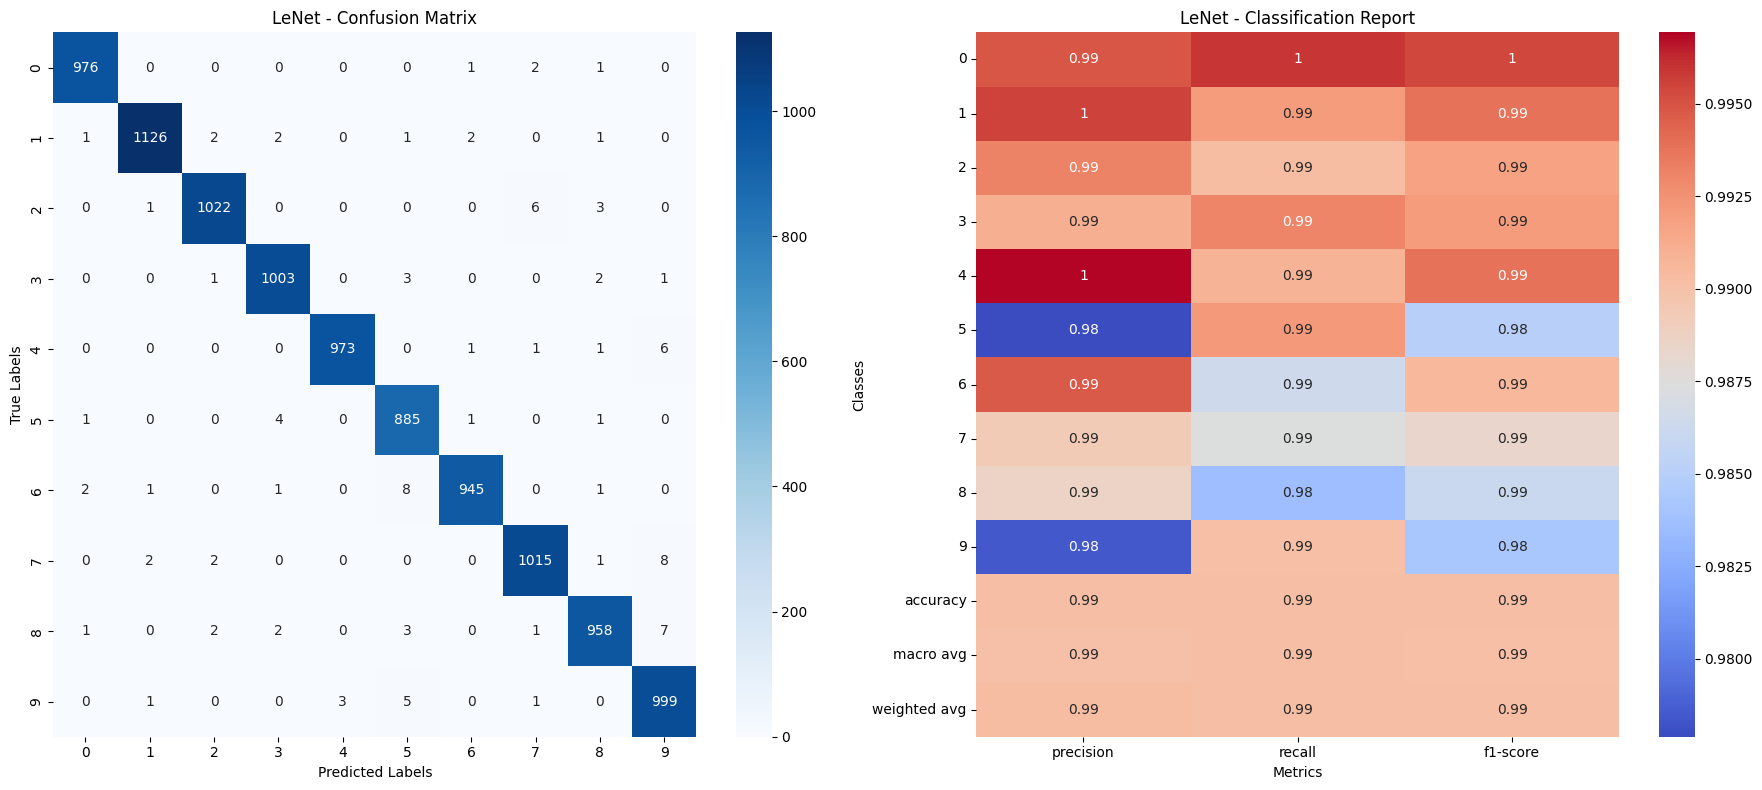

In [17]:
model = LeNetModel.load_from_checkpoint("lightning_logs/leNet/version_8/checkpoints/best.ckpt")
evaluate_model(None, "LeNet", is_nn=True, nn_model_instance=model)

## Unsupervised Learning

In [28]:
class LitAutoencoder(BaseLightningModel):
    def __init__(self, input_dim=784, hidden_dim1=512, hidden_dim2=256, latent_dim=2, learning_rate=1e-3):
        super().__init__(model_name='Autoencoder', learning_rate=learning_rate)
        self.save_hyperparameters()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        return self.decoder(z)

    def _common_step(self, batch, stage):
        x, _ = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log(f'{stage}_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, 'val')

    def generate(self, z):
        with torch.no_grad():
            generated = self.decoder(z)
            return generated.view(-1, 1, 28, 28)

    def to_latent(self, dataloader):
        self.eval()
        self.to('cpu')
        latent_vectors = []
        labels_list = []
        with torch.no_grad():
            for batch in dataloader:
                x, y = batch
                x = x.view(x.size(0), -1)
                z = self.encoder(x)
                latent_vectors.append(z.cpu().numpy())
                labels_list.append(y.cpu().numpy())
        return np.concatenate(latent_vectors), np.concatenate(labels_list)
    


In [28]:

model = LitAutoencoder(learning_rate=1e-3)
train_loader, val_loader, test_loader = prepare_data(sklearn=False)
trainer = pl.Trainer(
    max_epochs=20,
    logger=TensorBoardLogger("lightning_logs", name="autoencoder"),
    callbacks=[model.checkpoint_callback],
    accelerator='auto'
)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 533 K  | train
1 | decoder | Sequential | 534 K  | train
-----------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.273     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/mnist/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniconda/base/envs/mnist/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


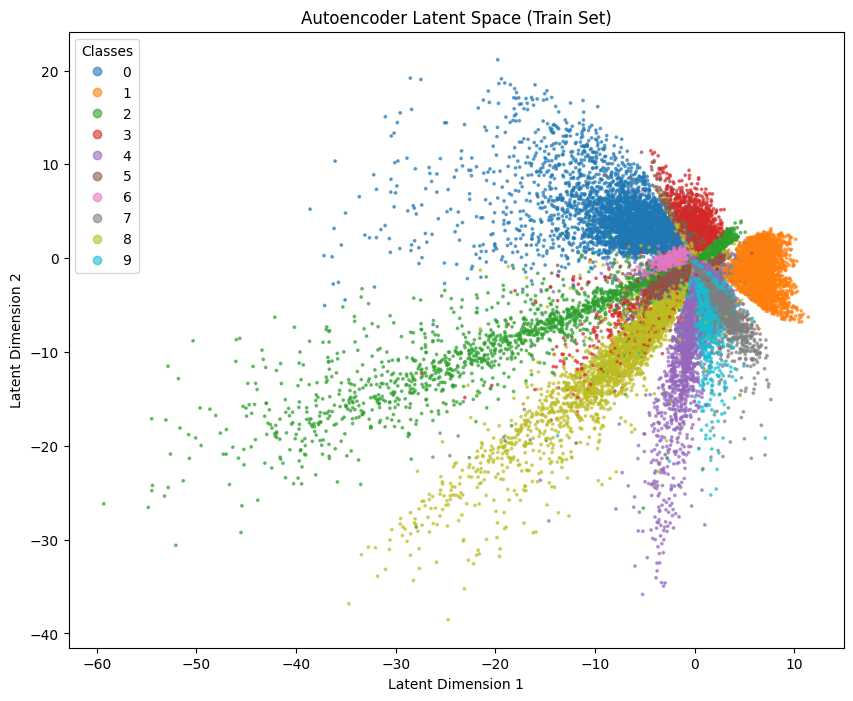

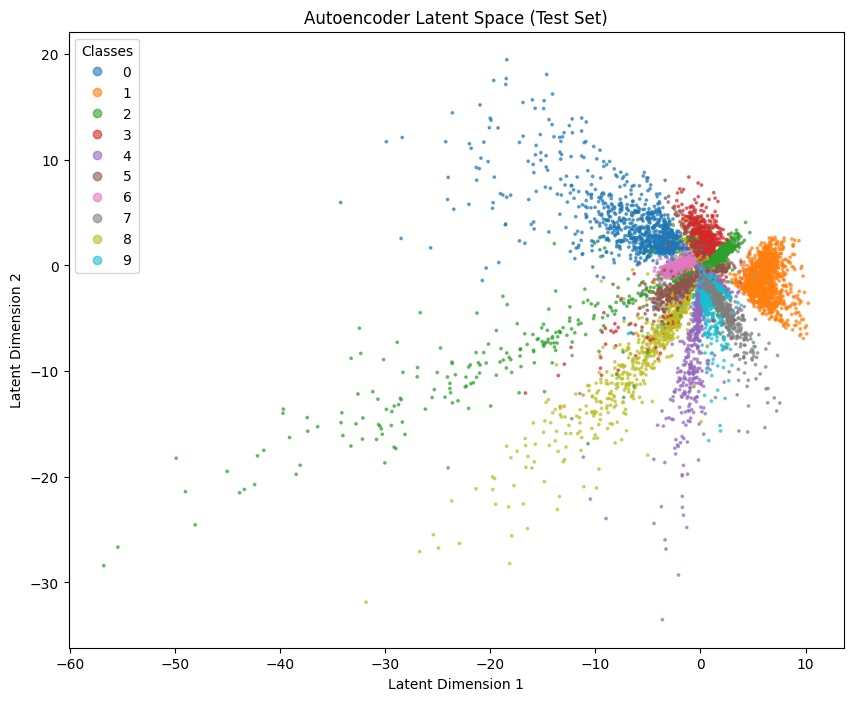

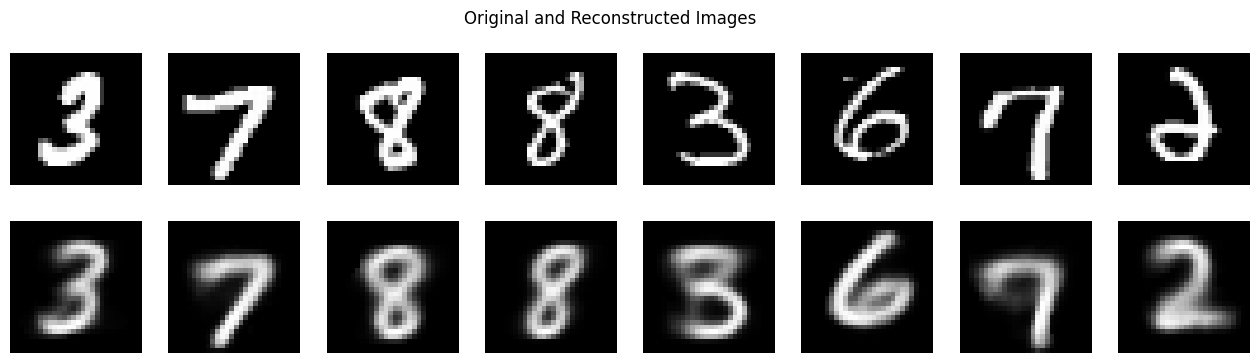

Generating some random images around center (0, 0) in latent space...


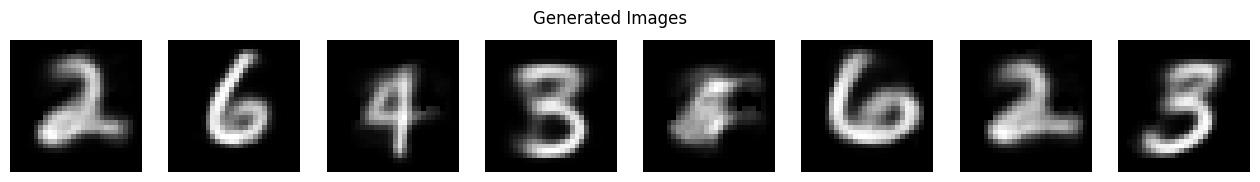

Generating some random images around center (-5, -10) in latent space...


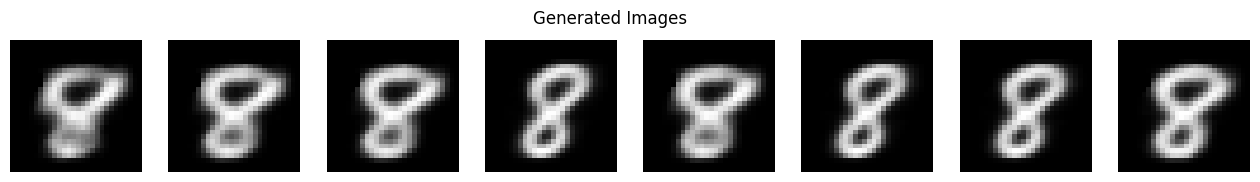

Generating some random images around center (-10, -10) in latent space...


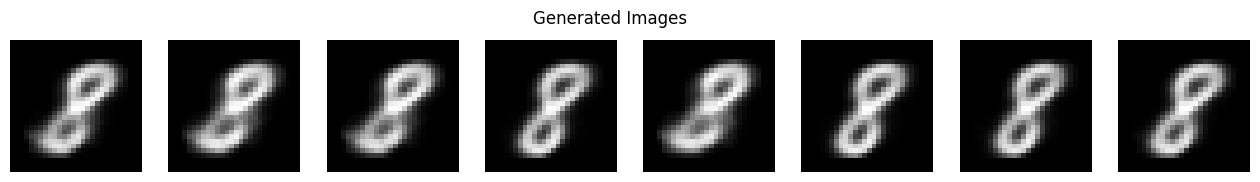

In [29]:
model = LitAutoencoder.load_from_checkpoint("lightning_logs/autoencoder/version_3/checkpoints/best.ckpt")
latent_vectors, labels = model.to_latent(train_loader)
model.plot_latent_space(latent_vectors, labels, title="Autoencoder Latent Space (Train Set)")

latent_test, labels_test = model.to_latent(test_loader)
model.plot_latent_space(latent_test, labels_test, title="Autoencoder Latent Space (Test Set)")

original = next(iter(train_loader))[0][:8]
recon = model(original)
model.plot_reconstructed_images(original, recon)

print("Generating some random images around center (0, 0) in latent space...")
noise =  torch.randn(8, 2)
generated = model.generate(noise)
model.plot_generated_images(generated)

# Generate some noise centered around (-5, -10)
z2 = torch.randn(8, 2) + torch.tensor([-5, -10]).float()
generated2 = model.generate(z2)
print("Generating some random images around center (-5, -10) in latent space...")
model.plot_generated_images(generated2)

#(-10, -10)
z3 = torch.randn(8, 2) + torch.tensor([-10, -10]).float()
generated3 = model.generate(z3)
print("Generating some random images around center (-10, -10) in latent space...")
model.plot_generated_images(generated3)

In [30]:
class VAEModel(BaseLightningModel):
    def __init__(self, x_dim=784, h_dim1=512, h_dim2=256, z_dim=2, learning_rate=1e-3):
        super().__init__(model_name='VAE', learning_rate=learning_rate)
        self.save_hyperparameters()

        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)  # Mean
        self.fc32 = nn.Linear(h_dim2, z_dim)  # Log variance

        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

    def loss_function(self, recon_x, x, mu, log_var):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum') / x.size(0)
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / x.size(0)
        total_loss = BCE + KLD
        return total_loss, BCE, KLD
    
    def _common_step(self, batch, stage):
        x, _ = batch
        recon_x, mu, log_var = self(x)
        total_loss, bce, kld = self.loss_function(recon_x, x, mu, log_var)
        self.log(f'{stage}_loss', total_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log(f'{stage}_bce', bce, on_step=False, on_epoch=True)
        self.log(f'{stage}_kld', kld, on_step=False, on_epoch=True)
        return total_loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, 'val')

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, 'test')

    def generate(self, z):
        with torch.no_grad():
            generated = self.decoder(z)
            return generated.view(-1, 1, 28, 28)

    def to_latent(self, dataloader):
        self.eval()
        self.to('cpu')
        latent_vectors = []
        labels_list = []
        with torch.no_grad():
            for batch in dataloader:
                x, y = batch
                x = x.view(x.size(0), -1)
                mu, log_var = self.encoder(x)
                latent_vectors.append(mu.cpu().numpy())
                labels_list.append(y.cpu().numpy())
        return np.concatenate(latent_vectors), np.concatenate(labels_list)
    

In [32]:
model = VAEModel(learning_rate=1e-3)
trainer = pl.Trainer(
    max_epochs=100,
    logger=TensorBoardLogger("lightning_logs", name="vae"),
    callbacks=[model.checkpoint_callback],
    accelerator='auto'
)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 401 K  | train
1 | fc2  | Linear | 131 K  | train
2 | fc31 | Linear | 514    | train
3 | fc32 | Linear | 514    | train
4 | fc4  | Linear | 768    | train
5 | fc5  | Linear | 131 K  | train
6 | fc6  | Linear | 402 K  | train
----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.275     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/mnist/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniconda/base/envs/mnist/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


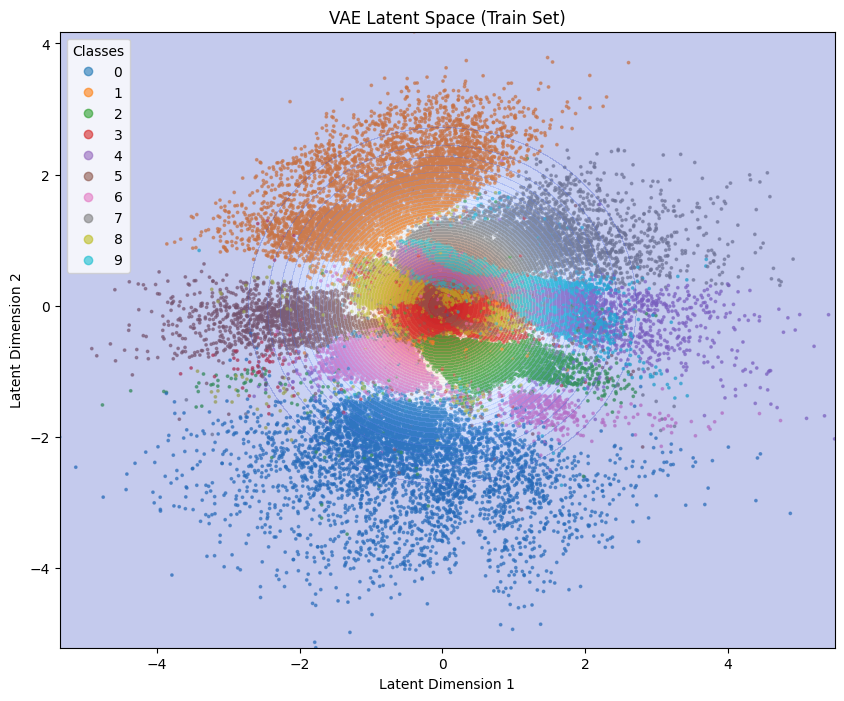

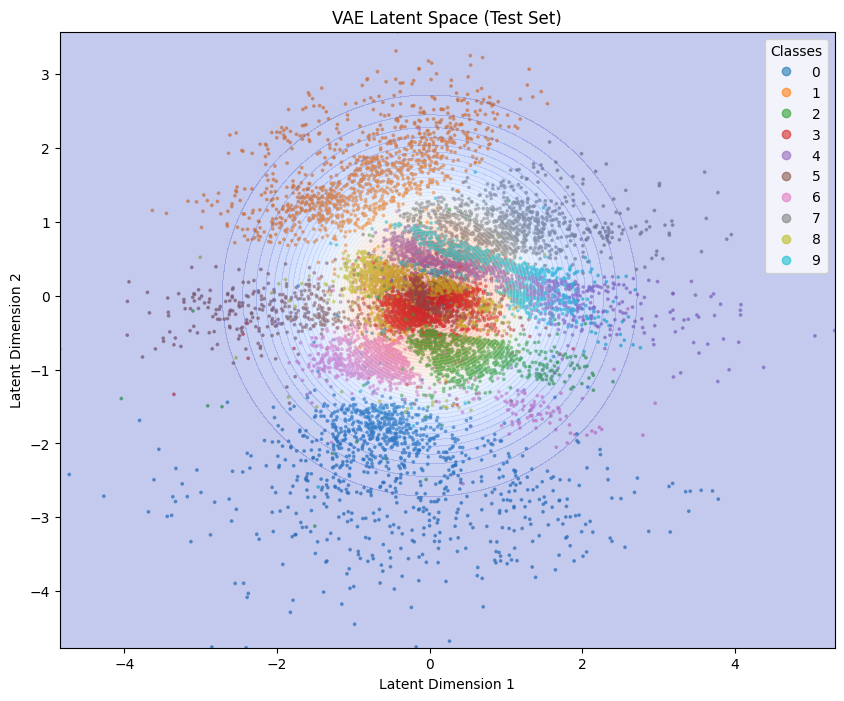

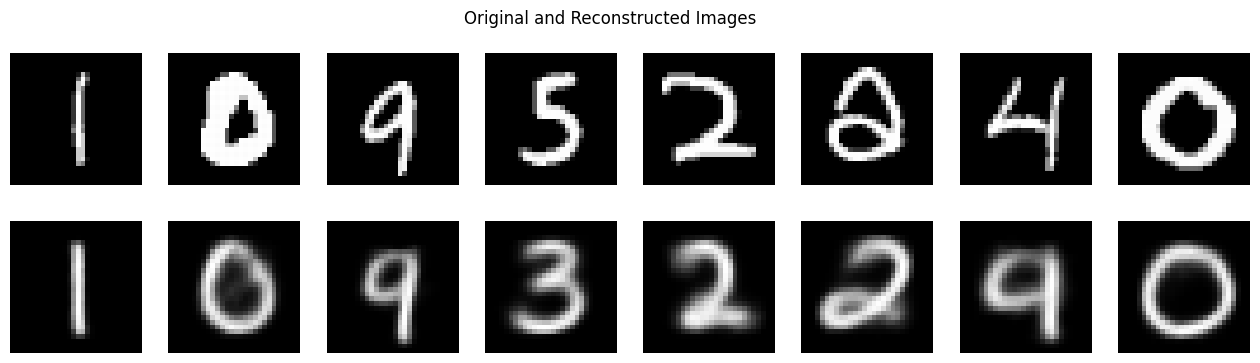

Generating some random images around center (0, 0) in latent space...


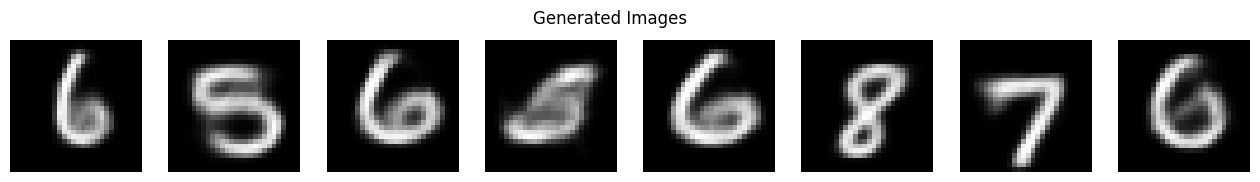

In [33]:
model = VAEModel.load_from_checkpoint("lightning_logs/vae/version_3/checkpoints/best.ckpt")
latent_vectors, labels = model.to_latent(train_loader)
model.plot_latent_space(latent_vectors, labels, title="VAE Latent Space (Train Set)", vae=True)

latent_test, labels_test = model.to_latent(test_loader)
model.plot_latent_space(latent_test, labels_test, title="VAE Latent Space (Test Set)", vae=True)

original = next(iter(train_loader))[0][:8]
recon, _, _ = model(original)
model.plot_reconstructed_images(original, recon)

print("Generating some random images around center (0, 0) in latent space...")
noise =  torch.randn(8, 2)
generated = model.generate(noise)
model.plot_generated_images(generated)